# Vintage analysis
- Autor: Victor Quilca

Contexto:
- Algunas posibles traducciones al español de "vintage analysis" podrían ser "análisis de la evolución de la cartera", "análisis del rendimiento histórico de los préstamos" o "análisis de la calidad crediticia de los préstamos en el tiempo".
- El objetivo de este análisis es obtener cuáles serían los días y meses para definir el incumplimiento.

## 1. Librerias y funciones

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', 500)
plt.rcParams["figure.figsize"] = 10,4

## 2. Carga de datos

In [29]:
applicant = pd.read_csv('./DATA/application_record.csv',sep=',')

In [30]:
credit = pd.read_csv('./DATA/credit_record.csv',sep=',')
credit.head(5)

,ID,MONTHS_BALANCE,STATUS
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,C


- MONTHS_BALANCE: El mes de los datos extraídos es el punto de partida, hacia atrás. 0 es el mes actual, -1 es el mes anterior, y así sucesivamente
- STATUS: 0: 1-29 días de demora 1: 30-59 días de demora 2: 60-89 días de demora 3: 90-119 días de demora 4: 120-149 días de demora 5: Deudas vencidas o incobrables, cancelaciones de más de 150 días C: cancelado ese mes X: Sin préstamo ese mes

- Solución Kaggle: https://www.kaggle.com/code/rikdifos/eda-vintage-analysis/notebook

## 3. Analisis para obtener el target

El objetivo de este análsis es obtener que variable medirá el incumplimiento (variable objetivo o target), esta variable debe tener una componente de días de atraso y meses de desempeño.

- Solución Alternativa a continuación:

In [31]:
credit['MADURACION']= np.abs(credit['MONTHS_BALANCE'])
# Maduración significa su desempeño a 1,2,3,... meses

credit.head(5)

,ID,MONTHS_BALANCE,STATUS,MADURACION
0,5001711,0,X,0
1,5001711,-1,0,1
2,5001711,-2,0,2
3,5001711,-3,0,3
4,5001712,0,C,0


In [32]:
# Creamos flags que nos indican si el cliente se atraso 30, 60 o 90 dias
credit['DEF_30DIAS'] = np.where((credit['STATUS'] == '1') | (credit['STATUS'] == '2') | (credit['STATUS'] == '3' )| (credit['STATUS'] == '4' )| (credit['STATUS'] == '5'), 1, 0) 
credit['DEF_60DIAS'] = np.where((credit['STATUS'] == '2') | (credit['STATUS'] == '3' )| (credit['STATUS'] == '4' )| (credit['STATUS'] == '5'), 1, 0) 
credit['DEF_90DIAS'] = np.where((credit['STATUS'] == '3' )| (credit['STATUS'] == '4' )| (credit['STATUS'] == '5'), 1, 0) 

credit.head(5)

,ID,MONTHS_BALANCE,STATUS,MADURACION,DEF_30DIAS,DEF_60DIAS,DEF_90DIAS
0,5001711,0,X,0,0,0,0
1,5001711,-1,0,1,0,0,0
2,5001711,-2,0,2,0,0,0
3,5001711,-3,0,3,0,0,0
4,5001712,0,C,0,0,0,0


In [33]:
# Vamos a contar cuantos malos existe a una maduracion de 1,2,3,...meses
# por ejemplo que DEF_60DIAS = 96 y Maduracion = 1 significa que hay 96 clientes malos (superaron 60 dias de atraso) observando el mes 1 de desempeño
# por ejemplo que DEF_60DIAS = 77 y Maduracion = 8 significa que hay 77 clientes malos (superaron 60 dias de atraso) observando el mes 8 de desempeño

maduracion_db = credit[credit['MADURACION']>0].groupby('MADURACION').agg({'DEF_30DIAS':['sum'],'DEF_60DIAS':['sum'],'DEF_90DIAS':['sum']}).reset_index().copy()
maduracion_db

,MADURACION,DEF_30DIAS,DEF_60DIAS,DEF_90DIAS
,,sum,sum,sum
0,1,468,96,79
1,2,457,90,71
2,3,409,96,65
3,4,467,88,67
4,5,408,92,72
5,6,391,82,63
6,7,379,74,59
7,8,377,77,53
8,9,347,78,57


In [34]:
# Acumulamos la cantidad de malos
# si DEF_60DIAS_ACUM = 462 y Maduracion = 5 significa que en total existen 462 clientes malos (superaron 60 dias de atraso) observando hasta un desempeño de 5 (Maduracion=1,2,3,4,5)
# si DEF_90DIAS_ACUM = 820 y Maduracion = 12 significa que en total existen 820 clientes malos (superaron 90 dias de atraso) observando hasta un desempeño de 12 (Maduracion=1,2,3,4,5,...,12)

maduracion_db['DEF_30DIAS_ACUM'] = np.cumsum(maduracion_db['DEF_30DIAS'])
maduracion_db['DEF_60DIAS_ACUM'] = np.cumsum(maduracion_db['DEF_60DIAS'])
maduracion_db['DEF_90DIAS_ACUM'] = np.cumsum(maduracion_db['DEF_90DIAS'])

total_DEF_30DIAS = np.sum(maduracion_db['DEF_30DIAS'])
total_DEF_60DIAS = np.sum(maduracion_db['DEF_60DIAS'])
total_DEF_90DIAS = np.sum(maduracion_db['DEF_90DIAS'])

maduracion_db

,MADURACION,DEF_30DIAS,DEF_60DIAS,DEF_90DIAS,DEF_30DIAS_ACUM,DEF_60DIAS_ACUM,DEF_90DIAS_ACUM
,,sum,sum,sum,,,
0,1,468,96,79,468,96,79
1,2,457,90,71,925,186,150
2,3,409,96,65,1334,282,215
3,4,467,88,67,1801,370,282
4,5,408,92,72,2209,462,354
5,6,391,82,63,2600,544,417
6,7,379,74,59,2979,618,476
7,8,377,77,53,3356,695,529
8,9,347,78,57,3703,773,586


In [35]:
maduracion_db['%MALOS_ACUM_30DIAS'] = maduracion_db['DEF_30DIAS_ACUM']*100/total_DEF_30DIAS[0]
maduracion_db['%MALOS_ACUM_60DIAS'] = maduracion_db['DEF_60DIAS_ACUM']*100/total_DEF_60DIAS[0]
maduracion_db['%MALOS_ACUM_90DIAS'] = maduracion_db['DEF_90DIAS_ACUM']*100/total_DEF_90DIAS[0]

maduracion_db

,MADURACION,DEF_30DIAS,DEF_60DIAS,DEF_90DIAS,DEF_30DIAS_ACUM,DEF_60DIAS_ACUM,DEF_90DIAS_ACUM,%MALOS_ACUM_30DIAS,%MALOS_ACUM_60DIAS,%MALOS_ACUM_90DIAS
,,sum,sum,sum,,,,,,
0,1,468,96,79,468,96,79,3.393764,3.190429,3.657407
1,2,457,90,71,925,186,150,6.707759,6.181456,6.944444
2,3,409,96,65,1334,282,215,9.673677,9.371884,9.953704
3,4,467,88,67,1801,370,282,13.060189,12.296444,13.055556
4,5,408,92,72,2209,462,354,16.018854,15.353938,16.388889
5,6,391,82,63,2600,544,417,18.854242,18.079096,19.305556
6,7,379,74,59,2979,618,476,21.602611,20.538385,22.037037
7,8,377,77,53,3356,695,529,24.336476,23.097375,24.490741
8,9,347,78,57,3703,773,586,26.852792,25.689598,27.129630


- Se recomienda hacer un corte en la maduración (para definir nuestro target para medir el incumplimiento) cuando se supera el 50% del total de malos acumulados

In [36]:
# En nuestro caso, para un maduracion de 20 se acumula el 52.1% de malos a 60 dias lo cual significa que el 52.1% de clientes que superan los 60 dias de atraso son acumulados 
# observando hasta una maduracion de 20 meses

# En nuestro caso, para un maduracion de 40 se acumula el 86.7% de malos a 60 dias lo cual significa que el 86.7% de clientes que superan los 60 dias de atraso son acumulados 
# observando hasta una maduracion de 20 meses

# Lo cual tiene sentido, mientras más amplio es mi ventana de maduración entonces acumularé mayor cantidad de malos

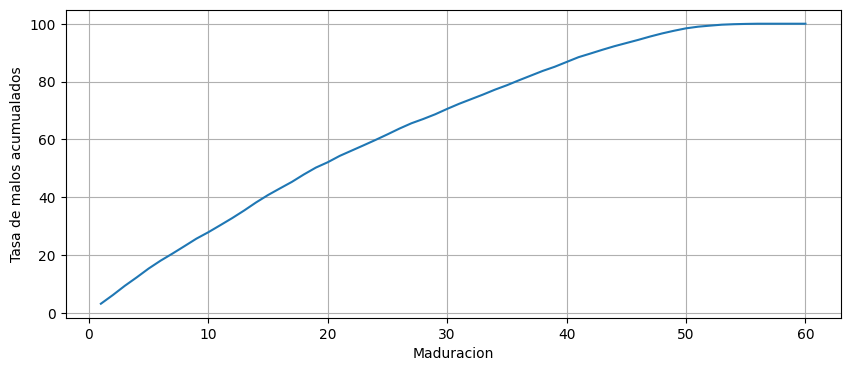

In [37]:
plt.plot(maduracion_db['MADURACION'],maduracion_db['%MALOS_ACUM_60DIAS'])
plt.xlabel('Maduracion')
plt.ylabel('Tasa de malos acumualados')
plt.grid()
plt.show()

- Solución según Kaggle: Podemos ver que una ventana de observación de 60 meses cubre a todos los solicitantes, mientras que la ventana de 20 meses contiene alrededor del 52% de los registros.

In [38]:
# Hemos llegado a la misma conclusión pero utilizando otro camino

**En este caso vamos a decir que el cliente incumple sus pagos cuando supera los 30 dias de atraso en un ventana de 24 meses (DEF_30D_24M) de tal manera que acumulemos un 59.47% de malos**

## 4. Construcción del target

In [39]:
pivot_tb = credit.pivot(index = 'ID', columns = 'MADURACION', values = 'STATUS').reset_index().rename_axis(None, axis=1)
pivot_tb

,ID,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60
0,5001711,X,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,5001712,C,C,C,C,C,C,C,C,C,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,5001713,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5001714,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5001715,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45980,5150482,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,C,C,C,C,C,C,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
45981,5150483,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
45982,5150484,C,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
45983,5150485,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [40]:
# consideraremos hasta una maduracion 24
pivot_tb_aux = pivot_tb.iloc[:,0:26]
# eliminarmos maduracion 0
pivot_tb_df = pivot_tb_aux.drop(pivot_tb_aux.columns[1], axis=1)
pivot_tb_df

,ID,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
0,5001711,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,5001712,C,C,C,C,C,C,C,C,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2,5001713,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,NaN,NaN,NaN
3,5001714,X,X,X,X,X,X,X,X,X,X,X,X,X,X,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5001715,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45980,5150482,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,C,C,C,C,C,C,0,0,0,0,0,0,0,0
45981,5150483,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,NaN,NaN,NaN,NaN,NaN,NaN,NaN
45982,5150484,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
45983,5150485,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [41]:
pivot_tb_df['DEF_30D_24M'] =  [1 if x >= 1 else 0 for x in np.sum((pivot_tb_df.values == '1') |(pivot_tb_df.values == '2') | (pivot_tb_df.values == '3') | (pivot_tb_df.values == '4')| (pivot_tb_df.values == '5'), 1)]
pivot_tb_df

,ID,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,DEF_30D_24M
0,5001711,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,5001712,C,C,C,C,C,C,C,C,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,0
2,5001713,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,NaN,NaN,NaN,0
3,5001714,X,X,X,X,X,X,X,X,X,X,X,X,X,X,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,5001715,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45980,5150482,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,C,C,C,C,C,C,0,0,0,0,0,0,0,0,0
45981,5150483,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
45982,5150484,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
45983,5150485,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [42]:
#pivot_tb_df[pivot_tb_df['DEF_30D_24M']==1]

In [43]:
bad_rate = pivot_tb_df['DEF_30D_24M'].mean()
print('Tasa de malos a modelar',bad_rate*100,'%')

Tasa de malos a modelar 7.371969120365336 %


## 5. Join variables y target

In [44]:
print(applicant['ID'].shape)
print(applicant['ID'].unique().shape)

(438557,)
(438510,)


In [45]:
print(pivot_tb_df['ID'].shape)
print(pivot_tb_df['ID'].unique().shape)

(45985,)
(45985,)


In [46]:
# Existen duplicados (cuidado con esto!!)

In [47]:
data = applicant.merge(pivot_tb_df[['ID','DEF_30D_24M']],on=['ID'],how='left')

In [48]:
data.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,DEF_30D_24M
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,1.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,1.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0,0.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,0.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,0.0


In [49]:
data.shape

(438557, 19)

In [50]:
# existen valores nulls en el default, los filtraremos

In [51]:
data_v2 = data[~data['DEF_30D_24M'].isnull()]
data_v2.shape

(36457, 19)

In [52]:
data_v2.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,DEF_30D_24M
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,1.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,1.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0,0.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,0.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,0.0


In [53]:
data_v2['ID'].unique().shape

(36457,)

In [54]:
bad_rate = data_v2['DEF_30D_24M'].mean()
print('Tasa de malos a modelar',bad_rate*100,'%')

Tasa de malos a modelar 7.460844282305182 %


In [57]:
# Exportando la data final para realizar el analisis exploratorio
data_v2.to_csv('./DATA/tc_applicant_target.csv',sep='|',index=False)

¡¡ Estamos listos para el análisis exploratorio!!